# The transient Universe

1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

In [2]:
def model(t, theta):
    A, b, t_0, alpha = theta
    return np.where(t < t_0, b, b + A * np.exp(-alpha * (t - t_0)))

def LogLikelihood(t, theta, sigma_y, y):
    model_values=[]
    model_values = [model(i, theta) for i in t]
    return -0.5 * np.sum((y-model_values)**2 / sigma_y**2 ) 

## prior is proportional to 1/alpha
def Logprior(theta):
    A,b,t0,alpha = theta 
    if Amin < A < Amax and bmin < b < bmax and t0min < t0 < t0max and alphamin < alpha < alphamax:
        return 0.0 + 0.0 + 0.0 - np.log(alpha)
    return -np.inf
                   
def LogPosterior(theta, t, sigma_y, y):
    return LogLikelihood(t, theta, sigma_y, y) + Logprior(theta)

## Visualization of the data

In [3]:
data= np.load('transient.npy')
times = data[:, 0]
fluxes = data[:, 1]
e_fluxes = data[:, 2]

Text(0, 0.5, 'Flux')

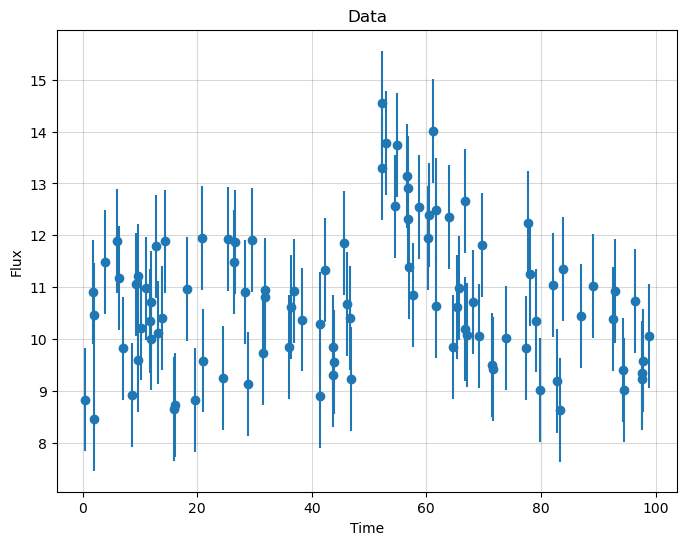

In [4]:
#Plot the data
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.errorbar(times, fluxes, e_fluxes, fmt='o')
ax.set_title('Data')
ax.grid(alpha=0.3, c = 'grey')
ax.set_xlabel('Time')
ax.set_ylabel('Flux')

Text(0, 0.5, 'Flux')

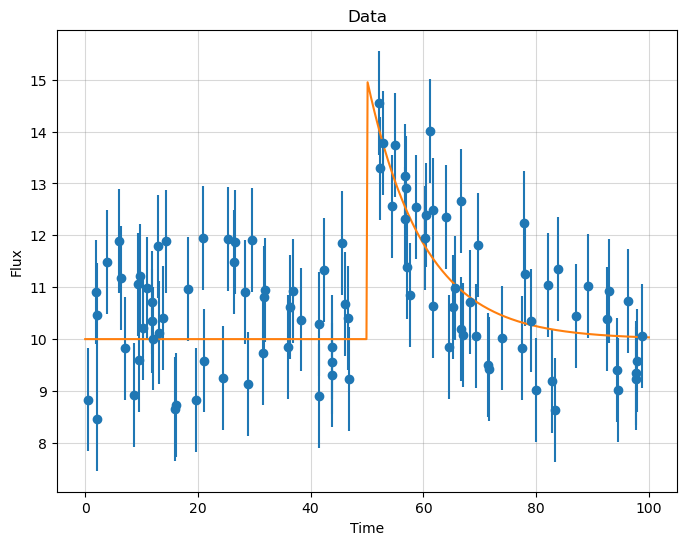

In [5]:
#Initial set of parameters
A = 5
b = 10
t_0 = 50
alpha = 0.1

theta= np.array([A, b, t_0, alpha])

tgrid = np.linspace(0, 100, 500)
fit = []
for i in tgrid:
    fit.append(model(i, theta))

fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.gca()
ax1.errorbar(times, fluxes, e_fluxes, fmt='o')
ax1.plot(tgrid, fit)
ax1.set_title('Data')
ax1.grid(alpha=0.3, c = 'grey')
ax1.set_xlabel('Time')
ax1.set_ylabel('Flux')


## MCMC with emcee

In [6]:
t0min,t0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)
   
#Compute the likelihood and the logPosterior
loglike = LogLikelihood(times, theta, e_fluxes, fluxes)
logpost = LogPosterior(theta, times, e_fluxes, fluxes)

In [10]:
#MCMC with emcee
ndim = 4  # number of parameters in the model
nwalkers = 20  # number of MCMC walkers
burn = 10000  # "burn-in" period to let chains stabilize
nsteps = 100000  # number of MCMC steps to take **for each walker**

#Initilize parameters 
starting_guesses = theta+ 1e-1* np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, args=[times, e_fluxes, fluxes])
sampler.run_mcmc(starting_guesses, nsteps, progress = True, store = True)

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [52:30<00:00, 31.74it/s]


State([[ 9.51323422 10.5381334  47.10479225  0.15454378]
 [ 7.20251597 10.25532592 47.95576513  0.12238551]
 [ 9.90525529 10.27023988 47.01712342  0.13656079]
 [11.17511064 10.07671965 47.75313362  0.16926306]
 [ 8.32979013 10.53350053 48.32678093  0.15585586]
 [ 5.44119286 10.22045197 51.09360092  0.16296856]
 [ 7.10151163 10.35622898 48.24938788  0.15437166]
 [ 4.46981084 10.39010667 50.68845689  0.11525292]
 [ 5.90530689 10.31144953 48.20209362  0.13712858]
 [ 7.54562073 10.0500143  49.36292415  0.1356607 ]
 [ 4.52115628  9.97031626 52.03674253  0.10801388]
 [ 4.58163528 10.29358902 50.72164561  0.12432149]
 [ 4.31824225 10.55354792 51.18511233  0.16171432]
 [ 7.14635548 10.22254241 47.01133262  0.11449537]
 [ 4.92112372 10.30505898 51.25116016  0.16708774]
 [ 5.79910782 10.38271889 49.87354405  0.13014805]
 [ 5.01487187 10.36508923 48.74414591  0.11310853]
 [ 6.22250899 10.33009787 49.27912811  0.14357769]
 [ 5.9926041  10.18635895 48.71521638  0.11358746]
 [10.44285941 10.17004248

### Visualization of the chains

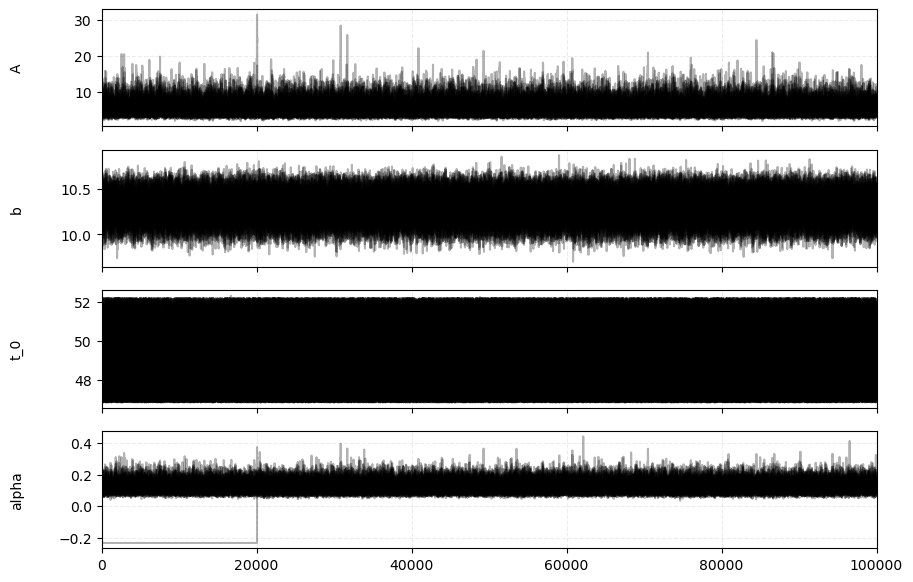

In [11]:
#Visualization of each chain
samples = sampler.get_chain()
labels = ["A","b","t_0","alpha"]
fig2, ax2 = plt.subplots(4, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax2[i].plot(samples[:, :, i], "k", alpha=0.3)
    ax2[i].set_xlim(0, len(samples))
    ax2[i].set_ylabel(labels[i])
    ax2[i].yaxis.set_label_coords(-0.1, 0.5)
    ax2[i].grid(c='grey', alpha=0.15, ls='--')

### Autocorrelation time for each chain

In [12]:
tau = sampler.get_autocorr_time()
print(tau)

[ 83.09451508  65.49763     82.78491895 125.90623105]


They are quiet big, we should try a thinning.

### Throw-out the burn-in phase and thinning

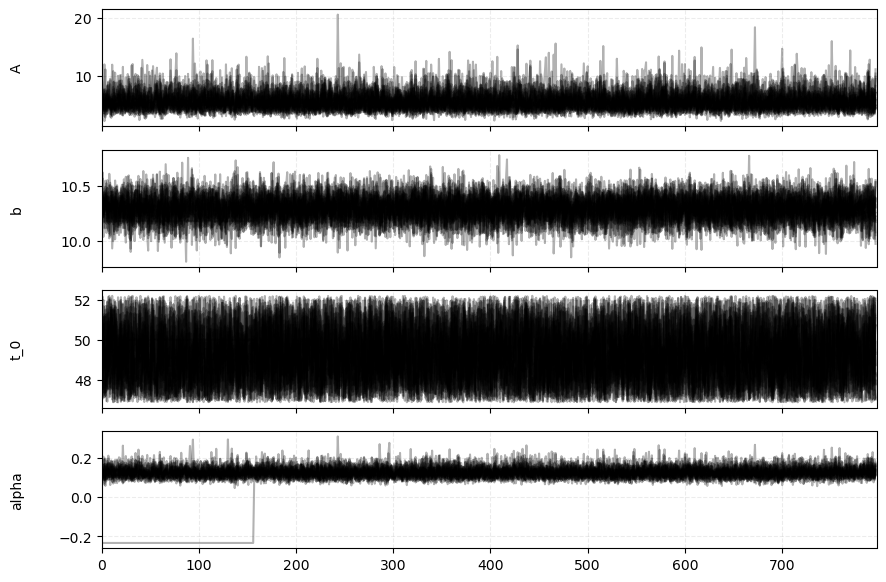

In [22]:
#Set the burn-in 
burn = 3*int(max(tau))

#Throw-out the burn-in points and thinning:
samples_burn  = sampler.get_chain(discard=burn, thin=int(max(tau)))

#Plot again the chains
fig3, ax3 = plt.subplots(4, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax3[i].plot(samples_burn[:, :, i], "k", alpha=0.3)
    ax3[i].set_xlim(0, len(samples_burn))
    ax3[i].set_ylabel(labels[i])
    ax3[i].yaxis.set_label_coords(-0.1, 0.5)
    ax3[i].grid(c='grey', alpha=0.15, ls='--')

### Corner plot

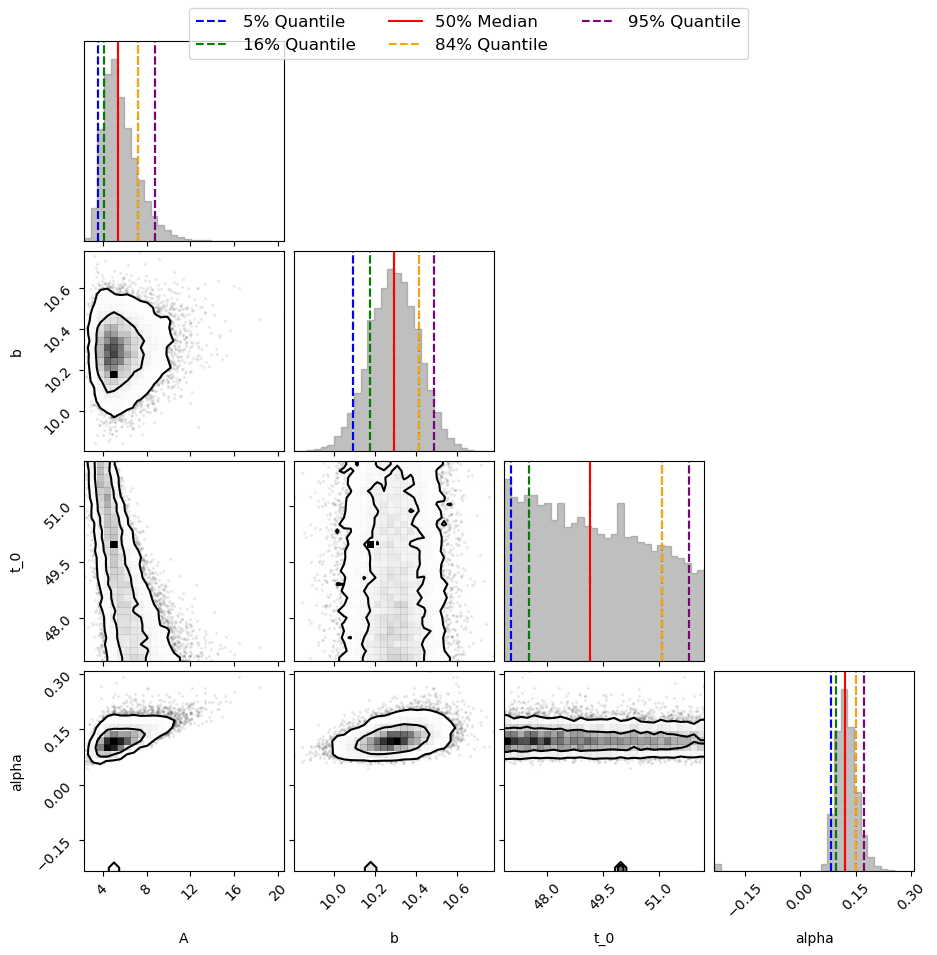

In [15]:
labels = ["A","b","t_0","alpha"]

#We need a 2D array to do the corner plot 
flat_samples = sampler.get_chain(discard=burn, thin=int(max(tau)), flat=True)

#Corner plot
fig = corner.corner(flat_samples, labels=labels, plot_datapoints = True, levels = [0.68,0.95], 
                    quantiles =[0.05, 0.16, 0.5, 0.84, 0.95], bins = 30, 
                    hist_kwargs={"fill": True, "color": "grey", "alpha": 0.5}, use_math_text=True)
#quantiles 16% and 84%: lower and upper bounds of 68% contour levels
#quantiles 5% e 95%: lower and upper bounds of 90% contour levels

quantile_colors = {
    '5%': 'blue',    
    '16%': 'green',
    '50%': 'red',
    '84%': 'orange',
    '95%': 'purple'
}

#Compute the quantiles
q05 = np.percentile(flat_samples, 5, axis=0)
q16 = np.percentile(flat_samples, 16, axis=0)
q50 = np.percentile(flat_samples, 50, axis=0)
q84 = np.percentile(flat_samples, 84, axis=0)
q95 = np.percentile(flat_samples, 95, axis=0)

#Add the coloured lines to the plot
for i in range(len(flat_samples[0])):
    ax = fig.axes[i + i * len(flat_samples[0])]  #Access to the right axes
    ax.axvline(q05[i], color=quantile_colors['5%'], linestyle="--", label="5% Quantile")
    ax.axvline(q16[i], color=quantile_colors['16%'], linestyle="--", label="16% Quantile")
    ax.axvline(q50[i], color=quantile_colors['50%'], linestyle="-", label="50% Median")
    ax.axvline(q84[i], color=quantile_colors['84%'], linestyle="--", label="84% Quantile")
    ax.axvline(q95[i], color=quantile_colors['95%'], linestyle="--", label="95% Quantile")

#Legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, fontsize=12)

plt.show()

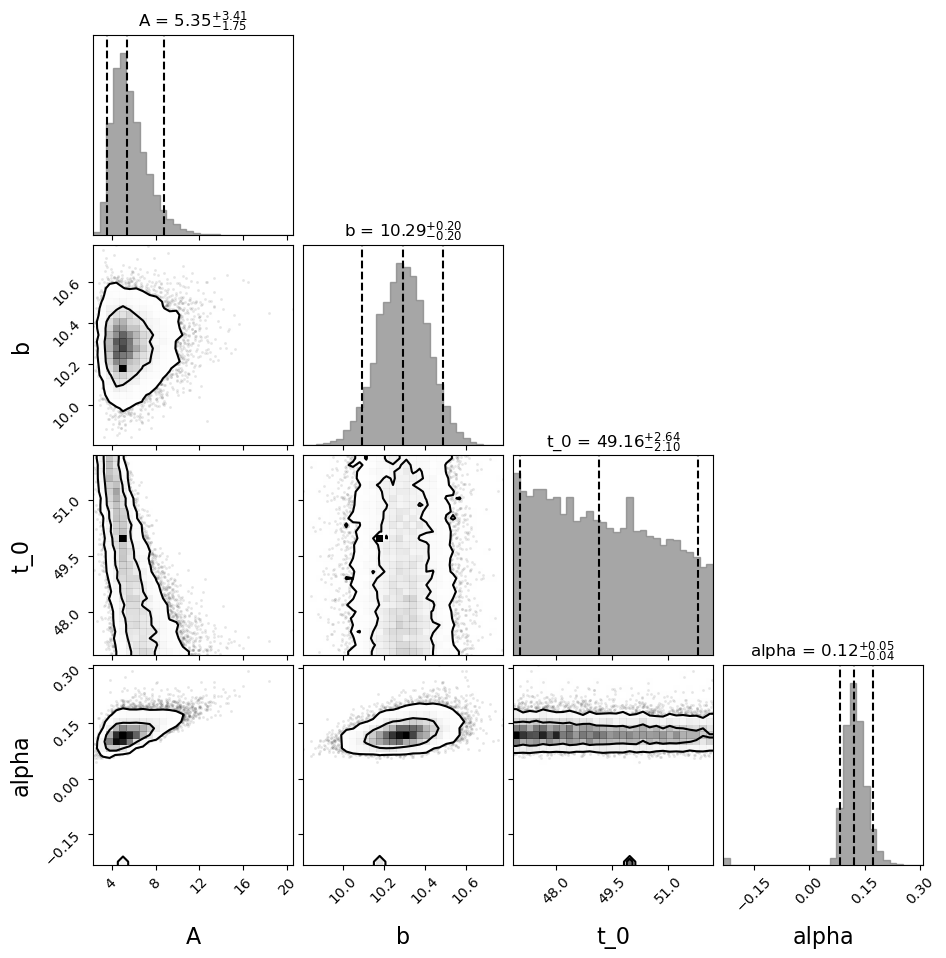

In [18]:
quantiles = [0.05, 0.5, 0.95]
labels = ["A","b","t_0","alpha"]

#Corner plot
fig = corner.corner(flat_samples, labels = labels, plot_datapoints = True, levels = [0.68,0.95], 
                    quantiles = quantiles, bins = 30, show_titles = True, title_fmt=".2f", label_kwargs={"fontsize": 16}, 
                    hist_kwargs={"fill": True, "color": "grey", "alpha": 0.7}, use_math_text=True)
#quantiles 16% and 84%: lower and upper bounds of 68% contour levels
#quantiles 5% e 95%: lower and upper bounds of 90% contour levels

## Select 100 set of parameters and plot the models with them

In [27]:
random_samples= np.array(flat_samples[np.random.choice(len(flat_samples),size=100)])

tgrid = np.linspace(0, 100, 500)
fit = []

for j in range(len(random_samples)):
    model_values=[]
    for i in tgrid:
        model_values.append(model(i, random_samples[j]))
    fit.append(model_values)

Text(0, 0.5, 'Flux')

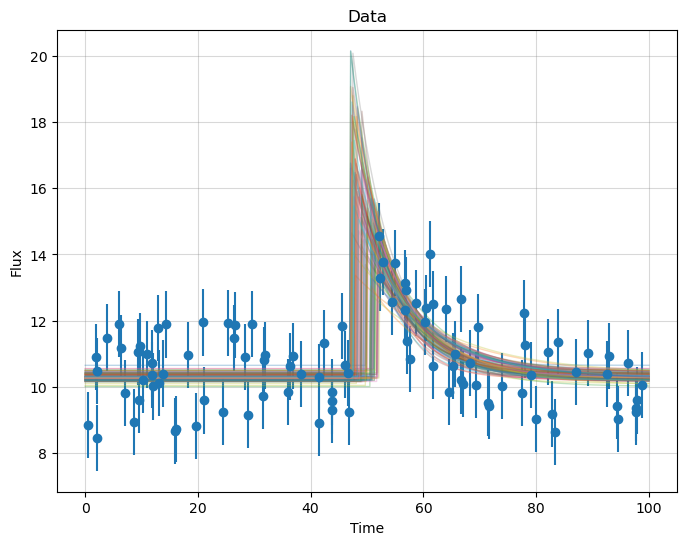

In [28]:
#Plot of the 100 corresponding burst time-series on a figure along with the original data.
fig3 = plt.figure(figsize=(8,6))
ax3 = fig3.gca()
ax3.errorbar(times, fluxes, e_fluxes, fmt='o')
for i in fit: 
 ax3.plot(tgrid, i, lw = 1, alpha = 0.3)
    
ax3.set_title('Data')
ax3.grid(alpha=0.3, c = 'grey')
ax3.set_xlabel('Time')
ax3.set_ylabel('Flux')